# Finalized classifier v2.0

Now all that's left to be done is wire up some routing logic between the models so we can easily do inference on incoming text. Workflow will looks something like this:

1. **Stage I features**: calculate perplexity ratio and TF-IDF based features for input text.
2. **Stage I classifier**: send feature vector to correct stage I classifiers based on text length.
3. **Stage II features**: create new feature vector for with stage I class probabilities, perplexity ration and TF-IDF features.
4. **Stage II classifier**: send new feature vector to correct stage II classifier for final prediction.

Each step requires assets from the feature engineering and classifier training phases. Let's make a checklist to help make sure we have everything in place.

1. **Stage I features**:
    - Perplexity ratio: tokenizer + reader and writer models.
    - Perplexity ratio Kullback-Leibler score: perplexity ratio Kullback-Leibler divergence kernel density estimate for each bin.
    - TF-IDF score: human and synthetic TF-IDF look-up tables for each bin.
    - TF-IDF Kullback-Leibler score: TF-IDF Kullback-Leibler divergence kernel density estimate for each bin.

2. **Stage I classifier**:
    - Trained XGBoost classifier model for each bin.

3. **Stage II features**
    - Perplexity ratio Kullback-Leibler score: perplexity ratio Kullback-Leibler divergence kernel density estimate for each bin.
    - TF-IDF score: human and synthetic TF-IDF look-up tables for each bin.
    - TF-IDF Kullback-Leibler score: TF-IDF Kullback-Leibler divergence kernel density estimate for each bin.

4. **Stage II classifier**
    - Trained XGBoost classifier model for each bin.

## 1. Notebook set-up

The plan is to break the inference pipeline into steps and run a process or process pool for each, using queues to move text through the pipeline. The major goal of this notebook will be to tune the pipeline in terms of resource allocation for each step to maximize the overall inference rate.

### 1.1. Imports

In [1]:
# Change working directory to parent so we can import as we would from main.py
print(f'Working directory: ', end = '')
%cd ..

# Standard imports
import pickle
import time
import random
from pathlib import Path

# PyPI imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from multiprocessing import Manager, Process
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Internal imports
import configuration as config
import functions.notebook_helper as helper_funcs

Working directory: /mnt/arkk/llm_detector/classifier


### 1.2. Notebook parameters

In [2]:
# Which experiments to run
pipeline_sanity_check=False
empty_queue_latency=False
full_queue_latency=False
queue_depth_latency=False
performance_test=False

# Results directories
results_directory=f'{config.PROJECT_ROOT_PATH}/notebooks/results'
figure_directory=f'{config.PROJECT_ROOT_PATH}/notebooks/figures'

### 1.3. Inference pipeline class

Let's start with a class for the inference pipeline - it will deal with setting up the queues and worker processes.

In [3]:
class InferencePipeline:
    '''Holds and manages processes and queues for inference pipeline.'''

    def __init__(self, gpus: list, queue_size: int=1000):

        self.gpus=gpus

        ##########################################################
        # Set-up queues to move text though through the pipeline #
        ##########################################################

        # Star the multiprocessing manager.
        self.manager=Manager()

        # Accepts input text and takes it to the LLM worker(s) for 
        # perplexity ratio calculation.
        self.input_queue=self.manager.Queue(maxsize=queue_size)

        # Takes text from LLM workers to the first stage classifier.
        self.stage_one_classifier_queue=self.manager.Queue(maxsize=queue_size)

        # Takes text from the first stage classifier to the 
        # second stage classifier.
        self.stage_two_classifier_queue=self.manager.Queue(maxsize=queue_size)

        # Returns completed work from the second stage classifier.
        self.output_queue=self.manager.Queue(maxsize=queue_size)

        ##########################################################
        # Set-up a process for each step in the pipeline #########
        ##########################################################

        # Set-up a perplexity ratio score worker for each gpu.
        self.perplexity_ratio_processes=[]
        for gpu in self.gpus:
            self.perplexity_ratio_processes.append(
                Process(
                    target=helper_funcs.get_perplexity_ratio,
                    args=(
                        self.input_queue,
                        self.stage_one_classifier_queue,
                        gpu
                    )
                )
            )

        # Does the feature engineering and classification for stage I.
        self.stage_one_classifier_process=Process(
            target=helper_funcs.stage_one_classifier,
            args=(
                self.stage_one_classifier_queue,
                self.stage_two_classifier_queue,
                len(gpus)
            )
        )

        # Does the feature engineering and classification for stage II.
        self.stage_two_classifier_process=Process(
            target=helper_funcs.stage_two_classifier,
            args=(
                self.stage_two_classifier_queue,
                self.output_queue
            )
        )


    def start(self):
        '''Starts the pipeline processes.'''

        # Start LLM worker processes for perplexity ratio scoring
        # and wait for 'ready' response before moving on.
        for gpu_worker in self.perplexity_ratio_processes:
            gpu_worker.start()
            _=self.stage_one_classifier_queue.get()

        # Start stage I classifier process
        # and wait for 'ready' response before moving on.
        self.stage_one_classifier_process.start()
        _=self.stage_two_classifier_queue.get()

        # Start stage II classifier process
        # and wait for 'ready' response before moving on.
        self.stage_two_classifier_process.start()
        _=self.output_queue.get()


    def stop(self):
        '''Stops pipeline processes and shuts down.'''

        # Send a done signal for each GPU worker
        for _ in range(len(self.gpus)):
            self.input_queue.put('done')

        # Join and then close each process
        for gpu_worker in self.perplexity_ratio_processes:
            gpu_worker.join()
            gpu_worker.close()

        self.stage_one_classifier_process.join()
        self.stage_one_classifier_process.close()

        self.stage_two_classifier_process.join()
        self.stage_two_classifier_process.close()

        # Close the queues and stop the manager
        self.manager.shutdown()

## 2. Inference pipeline sanity check

In [4]:
if pipeline_sanity_check is True:

    # Create a pipeline class instance and start the worker processes
    inference_pipeline=InferencePipeline(['cuda:1'])
    inference_pipeline.start()

    # Send some test text though and take a look at the results
    test_text='''Documentation says you can equip node pools with GPU(s). A node pool is a group of nodes that share the same configuration. A node is an individual machine that runs containerized applications. So right now, we are running 3 'containers' (the telegram bot, the classification API and redis) on one 'node' in a 'node pool' with one member: pyrite. The only thing I am having trouble wrapping my mind around is how this scales past one node. I.e., if we go from one node to two, we have two redis servers, two classification APIs and two bots. I don't think that's what we want , but I'm not sure. I can think of two possibilities, each of which imply further questions.'''

    # Start timer for total time
    start_time=time.time()

    # Do the inference
    inference_pipeline.input_queue.put(test_text)
    result=inference_pipeline.output_queue.get()

    # Stop the timer and get the total time-of-flight
    dT=time.time() - start_time

    print(f'Total time-of-flight: {dT:.2f} seconds.\n')

    print(f'Time-of-flight by task:')
    for task, dT in result['Time-of-flight'].items():
        print(f' {task}: {dT:.2f}')

    print(f'\nFeatures:')
    for key, value in result['Features'].items():
        if key == 'Text string':
            print(f' {key}: {value[:75]}...')

        else:
            print(f' {key}: {value}')

    # Stop the pipeline
    inference_pipeline.stop()

## 3. Inference pipeline latency benchmarking

Results look OK at first glance. Seems like the inference latency is around 10 seconds for a single text. Let's send a bunch of text fragments from the training data through and see if we can get a better estimate of how fast the pipeline actually is.

### 3.1. Training data loading

Load the stage I training data, take just the text and labels. We will be treating each fragment as if it were submitted by a user, i.e. all we will have is the text string. We will use the labels later to check the model's performance.

In [5]:
# Load the stage I training data and take just the text and labels

# Stage I dataset
dataset_name='falcon-7b_scores_v2_10-300_words_stage_I'

# Input file path
input_file=f'{config.DATA_PATH}/{dataset_name}.h5'

# Open the new hdf5 file with pandas so we can work with dataframes
data_lake=pd.HDFStore(input_file)

# Get the features and extract just the text
training_df=data_lake['training/combined/features']
texts=training_df['String'].to_list()
print(f'Have {len(texts)} training text fragments')

# Get the corresponding labels
labels=data_lake['training/combined/labels'].to_list()
print(f'Have {len(labels)} training text fragment labels')

# Close the connection to the hdf5 file
data_lake.close()

training_df.head()

Have 39042 training text fragments
Have 39042 training text fragment labels


,Fragment length (words),Fragment length (tokens),Source,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio score Kullback-Leibler divergence,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,TF-IDF score Kullback-Leibler divergence
0,32,46,human,It’s a disease people just don’t know about. T...,3.127,2.832031,1.104138,0.473190,-3.385168,-3.422211,-0.252168,0.071449
1,27,45,human,Owens(c) vs Roman Reigns – WWE Universal Champ...,2.912,3.027344,0.961935,0.120746,-2.634773,-2.650256,-0.081826,0.067688
2,268,371,synthetic,chemical or pharmaceutical processes.\nhowever...,2.193,2.675781,0.819708,3.325138,-2.862300,-2.877875,-0.089403,0.067875
3,112,131,human,unstable area near the Iraq and Syria border. ...,2.730,2.695312,1.013043,0.203559,-3.475644,-3.331192,0.983256,0.037913
4,32,44,synthetic,"ins , is encoded by a gene family with at leas...",3.025,3.693359,0.819143,3.306112,-2.650665,-2.901612,-1.393327,0.069538


### 3.2. Empty queue inference latency

#### 3.2.1. Run parameters

In [6]:
# Number of text samples to send
batch_size=250

# Holder for results
inference_times={
    'Total': [],
    'Perplexity ratio calculation': [],
    'Stage I classification': [],
    'Stage II classification': []
}

# File to save the results
results_file=f'{results_directory}/05.8.3.2.2-empty_queue_benchmark.pkl'

#### 3.2.2. Benchmark

In [7]:
%%time

if empty_queue_latency is True:

    # Create a pipeline class instance and start the worker processes
    inference_pipeline=InferencePipeline(['cuda:1'])
    inference_pipeline.start()

    # Grab a random sample of texts for this batch
    batch=random.sample(texts, batch_size)

    # Counter for texts processed - in case we skip some due to 
    # errors in the pipeline
    text_count=0

    # Loop on the batch and run inference on each text
    for i, text in enumerate(batch):

        # Record total time-of-flight for this text
        start_time=time.time()

        # Do the inference
        inference_pipeline.input_queue.put(text)
        result=inference_pipeline.output_queue.get()

        # Stop the total time-of-flight timer
        dT=time.time() - start_time

        # Check to make sure we got a good result
        if result['Status'] == 'OK':

            # Collect the times
            inference_times['Total'].append(dT)
            inference_times['Perplexity ratio calculation'].append(result['Time-of-flight']['Perplexity ratio calculation (seconds)'])
            inference_times['Stage I classification'].append(result['Time-of-flight']['Stage I classifier (seconds)'])
            inference_times['Stage II classification'].append(result['Time-of-flight']['Stage II classifier (seconds)'])
    
    inference_pipeline.stop()

    # Save the result
    with open(results_file, 'wb') as output:
        pickle.dump(inference_times, output, pickle.HIGHEST_PROTOCOL)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.58 µs


#### 3.2.3. Results

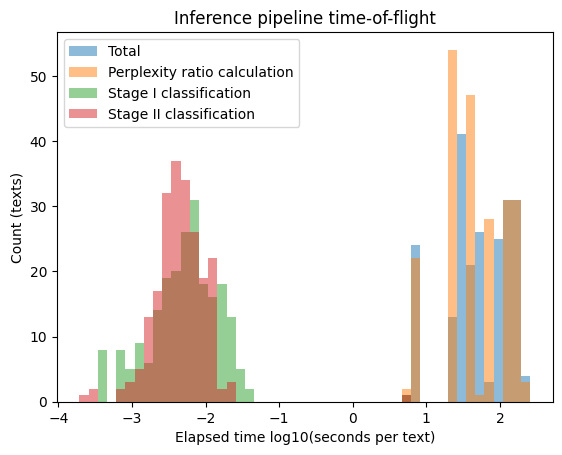

In [8]:
if Path(results_file).is_file():

    # Load the data
    with open(results_file, 'rb') as input_file:
        inference_times=pickle.load(input_file)

    # Create dataset-wide bins
    min_time=min(min(np.log(times)) for times in inference_times.values())
    max_time=max(max(np.log(times)) for times in inference_times.values())
    bins=np.linspace(min_time, max_time, num=50)

    plt.title('Inference pipeline time-of-flight')
    plt.xlabel('Elapsed time log10(seconds per text)')
    plt.ylabel('Count (texts)')

    for variable, times in inference_times.items():

        plt.hist(np.log(times), label=variable, bins=bins, alpha=0.5)

    plt.legend(loc='best')
    plt.savefig(f'{figure_directory}/05.8.3.2.3-empty_queue_benchmark.jpg')
    plt.show()

Not surprisingly, the perplexity ratio calculation accounts for almost all of the net inference time. This is going to be hard to get around, it's the step that uses two LLMs to score the text. We barely have enough local compute to run two GPU worker processes - each one needs ~12 GB GPU memory. Seems like the only way to scale effectively is more GPU nodes or more GPUs per node...

Let's at least try 1 vs 2 GPU workers locally. To see any difference, I think we need to submit the text a different way - rather than submitting one text at a time to the input queue and timing how long it takes to come out the other end - let's put a big batch of texts in all at once and time how long it takes to recover all of them. Hypothesis here is that two GPU workers should cut the average time down, even though the time-of-flight for any one text will remain the same. This is a better representation of an end-user's experience anyway. Imagine you just submitted something but there are 10 people in the queue ahead of you - it will take 10 seconds for each fragment already in the queue and then 10 seconds for yours. If we can process two fragments at once it will cut your wait time down from 110 seconds to 60 seconds, even though it still took 10 seconds to process your text..

### 3.3. Full queue latency: 1 vs 2 GPU workers

#### 3.3.1. Run parameters

In [9]:
# GPUs to run jobs on
gpu_worker_lists=[['cuda:1'],['cuda:1','cuda:2']]

# Number of texts to score
batch_size=100

# Holder for results
inference_times={}

# File to save the results
results_file=f'{results_directory}/05.8.3.3.2-full_queue_benchmark.pkl'

#### 3.3.2. Benchmark

In [10]:
%%time

if full_queue_latency is True:

    # Loop on the GPU worker lists
    for gpus in gpu_worker_lists:

        print(f'\nRunning batch with {len(gpus)} GPU workers')

        # Create a pipeline class instance and start the worker processes
        inference_pipeline=InferencePipeline(gpus)
        inference_pipeline.start()

        # Add a key and list to the results for this worker count to collect average rates
        inference_times[f'{len(gpus)} GPU workers']=[]

        # Grab a random sample of texts for this batch
        batch=random.sample(texts, batch_size)

        # Start the timer
        start_time=time.time()

        # Put all of the text in the queue
        print(f' Submitting {batch_size} texts to queue')
        
        for i, text in enumerate(batch):
            inference_pipeline.input_queue.put(text)

        print(' Done submitting text')

        # Send a special done text in
        for gpu in gpus:
            inference_pipeline.input_queue.put(' '.join(['This is the done signal!!!']*10))

        print(f' Waiting...')

        # Loop, collecting output arrival times until we get done signal back from all GPU workers
        done_count=0

        while True:
            result=inference_pipeline.output_queue.get()

            if result['Status'] == 'OK':
                if 'This is the done signal!!!' in result['Features']['Text string']:
                    done_count+=1
                    if done_count == len(gpus):
                        break

                dT=time.time() - start_time
                inference_times[f'{len(gpus)} GPU workers'].append(dT)
    
        # Cleanly finish shutting the pipeline down
        inference_pipeline.stop()

    # Save the result
    with open(results_file, 'wb') as output:
        pickle.dump(inference_times, output, pickle.HIGHEST_PROTOCOL)

    print()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.54 µs


#### 3.3.3. Results

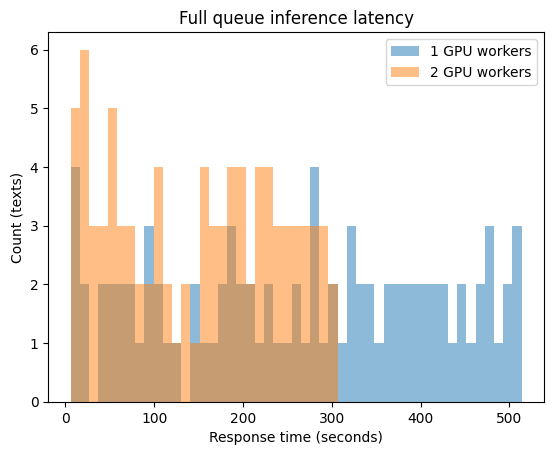

In [11]:
if Path(results_file).is_file():

    # Load the data
    with open(results_file, 'rb') as input_file:
        inference_times=pickle.load(input_file)

    plt.title('Full queue inference latency')
    plt.xlabel('Response time (seconds)')
    plt.ylabel('Count (texts)')

    # Create dataset-wide bins
    min_inference_time=min(min(inference_time) for inference_time in inference_times.values())
    max_inference_time=max(max(inference_time) for inference_time in inference_times.values())
    bins=np.linspace(min_inference_time, max_inference_time, num=50)

    for variable, times in inference_times.items():

        plt.hist(times, label=variable, bins=bins, alpha=0.5)

    plt.legend(loc='best')
    plt.savefig(f'{figure_directory}/05.8.3.3.3-full_queue_benchmark.jpg')
    plt.show()

Result as expected - the wait times for a long queue gets excessive, but adding a second GPU worker roughly halves the maximum wait time. I'd expect this benefit to remain linear until the classification workers become a bottleneck.

### 3.4. Latency as a function of queue depth

For bonus points, let's come up with a scaling law, i.e. what's the worst case scenario for latency as the queue gets longer and does adding an extra GPU worker help? (yes). We should also be able to see the minimum latency is independent of both the queue length and the number of GPU workers.

#### 3.4.1. Run parameters

In [12]:
# GPUs to run jobs on
gpu_worker_lists=[['cuda:1'],['cuda:1','cuda:2']]

# Number of texts to add to the queue
queue_depths=[1,2,4,8,16,32]

# Number of replicates to run for each queue depth
replicates=5

# Holder for results
max_inference_times={}
min_inference_times={}

# File to save the results
results_file=f'{results_directory}/05.8.3.4.2-queue_depth_benchmark.pkl'

#### 3.4.2. Benchmark

In [13]:
%%time

if queue_depth_latency is True:

    # Loop on the GPU worker lists
    for gpus in gpu_worker_lists:

        # Create a pipeline class instance and start the worker processes
        inference_pipeline=InferencePipeline(gpus)
        inference_pipeline.start()

        # Add a key to the results for this GPU count to hold the queue depth and the time
        min_inference_times[f'{len(gpus)} GPU workers']={}
        max_inference_times[f'{len(gpus)} GPU workers']={}

        # Loop on the queue depths
        for queue_depth in queue_depths:
            print(f'Running queue depth {queue_depth} with {len(gpus)} GPU workers')

            # Add a key to the results for this queue depth to hold the time
            min_inference_times[f'{len(gpus)} GPU workers'][f'Queue depth {queue_depth}']=[]
            max_inference_times[f'{len(gpus)} GPU workers'][f'Queue depth {queue_depth}']=[]

            # Finally, loop on the replicates of this queue depth
            for replicate in range(replicates):

                # Grab a random sample of texts of size queue_depth for this batch
                batch=random.sample(texts, queue_depth)

                # Holder to collect time-of-flight for each fragment
                dTs=[]

                # Start the timer
                start_time=time.time()
                
                # Put all of the text in the queue
                for i, text in enumerate(batch):
                    inference_pipeline.input_queue.put(text)

                # Send a special done text in
                for gpu in gpus:
                    inference_pipeline.input_queue.put(' '.join(['This is the done signal!!!']*10))

                # Loop, collecting output arrival times until we get done signal back from all GPU workers
                done_count=0

                while True:
                    result=inference_pipeline.output_queue.get()

                    if result['Status'] == 'OK':
                        if 'This is the done signal!!!' in result['Features']['Text string']:
                            done_count+=1
                            if done_count == len(gpus):
                                break

                        dTs.append(time.time() - start_time)

                # Collect the min and max time-of-flight for this replicate, making sure we have data first
                if len(dTs) != 0:
                    max_inference_times[f'{len(gpus)} GPU workers'][f'Queue depth {queue_depth}'].append(max(dTs))
                    min_inference_times[f'{len(gpus)} GPU workers'][f'Queue depth {queue_depth}'].append(min(dTs))
                
        # Shut the pipeline down
        inference_pipeline.stop()

    # Save the result
    with open(results_file, 'wb') as output:
        inference_times={
            'max_inference_times': max_inference_times,
            'min_inference_times': min_inference_times
        }
        pickle.dump(inference_times, output, pickle.HIGHEST_PROTOCOL)

    print()

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.54 µs


#### 3.4.3. Results

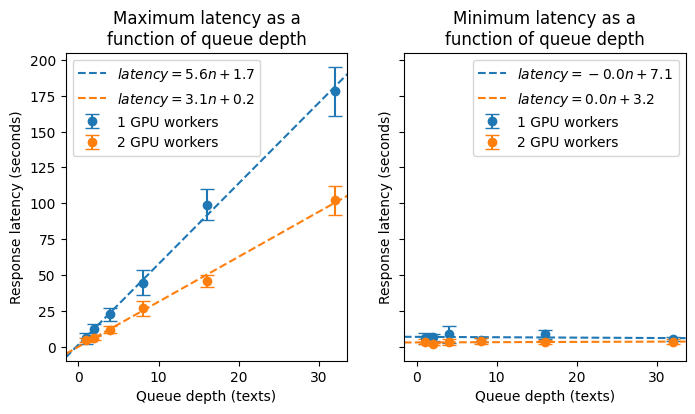

In [14]:
if Path(results_file).is_file():

    # Load the data
    with open(results_file, 'rb') as input_file:
        inference_times=pickle.load(input_file)

    min_inference_times=inference_times['min_inference_times']
    max_inference_times=inference_times['max_inference_times']

    # Set-up two subplots
    _, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
    
    # Set the plot titles
    axes[0].set_title('Maximum latency as a\nfunction of queue depth')
    axes[1].set_title('Minimum latency as a\nfunction of queue depth')

    # Loop on the subplots and their corresponding data
    for ax, inference_times in zip(axes, [max_inference_times, min_inference_times]):

        colors=['tab:blue', 'tab:orange']

        # Loop on the gpu workers lists to plot a series for each
        for gpus, color in zip(gpu_worker_lists, colors):

            # Get mean and standard deviation for error bar plot
            data=inference_times[f'{len(gpus)} GPU workers']
            standard_deviations=[]
            means=[]

            for queue_depth in queue_depths:
                times=data[f'Queue depth {queue_depth}']
                means.append(np.mean(times))
                standard_deviations.append(np.std(times))

            # Draw the error bar series
            ax.errorbar(
                queue_depths, 
                means, 
                yerr=standard_deviations, 
                linestyle='none',
                marker='o',
                c=color,
                capsize=5,
                label=f'{len(gpus)} GPU workers'
            )

            # Do a linear fit
            model=sm.OLS(means, sm.add_constant(queue_depths))
            results=model.fit()

            # Extract intercept b and slope m
            b, m = results.params

            # Plot as y = m*x + b
            ax.axline(
                xy1=(0, b),
                slope=m,
                linestyle='dashed',
                c=color,
                label=f'$latency = {m:.1f}n {b:+.1f}$'
            )

        # Label the axes
        ax.set_xlabel('Queue depth (texts)')
        ax.set_ylabel('Response latency (seconds)')

        # Draw a legend
        ax.legend(loc='best')

    plt.savefig(f'{figure_directory}/05.8.3.4.3-queue_depth_benchmark.jpg')
    plt.show()

Yep, so not surprisingly - adding a GPU worker approximately halves the max latency at all queue depths. But even with two workers (using a full 24 GB of GPU memory) the latency gets pretty bad quickly as the queue grows.

Unfortunately, I don't think there is much we can do but throw more GPUs at it. Google Cloud credits for the win! We are going to have to build with this in mind though - we don't want to task a bunch of GPUs right out of the gate and burn all of our credits waiting for people to show up - but if they do show up, we want to be prepared to scale and keep the wait times under control.

Ok, enough drag racing - let's make sure this thing is performing as expected and move on to getting it in a docker container. I want it in the cloud by the end of the weekend.

## 4. Inference pipeline performance

This should be easy - cross your fingers. All we need to do is run inference on a bunch of test data and compare the true class.

### 4.1. Test data loading

In [15]:
# Load the stage I testing data and take just the text and labels

# Stage I dataset
dataset_name='falcon-7b_scores_v2_10-300_words_stage_I'

# Input file path
input_file=f'{config.DATA_PATH}/{dataset_name}.h5'

# Open the new hdf5 file with pandas so we can work with dataframes
data_lake=pd.HDFStore(input_file)

# Get the features and extract just the text
testing_df=data_lake['testing/combined/features']
test_texts=training_df['String'].to_list()
print(f'Have {len(test_texts)} testing text fragments')

# Get the corresponding labels
test_labels=data_lake['testing/combined/labels'].to_list()
print(f'Have {len(test_labels)} testing text fragment labels')

# Close the connection to the hdf5 file
data_lake.close()

testing_df.head()

Have 39042 testing text fragments
Have 39042 testing text fragment labels


,Fragment length (words),Fragment length (tokens),Source,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio score Kullback-Leibler divergence,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,TF-IDF score Kullback-Leibler divergence
0,32,46,human,It’s a disease people just don’t know about. T...,3.127,2.832031,1.104138,0.473190,-3.385168,-3.422211,-0.252168,0.071449
1,27,45,human,Owens(c) vs Roman Reigns – WWE Universal Champ...,2.912,3.027344,0.961935,0.120746,-2.634773,-2.650256,-0.081826,0.067688
2,268,371,synthetic,chemical or pharmaceutical processes.\nhowever...,2.193,2.675781,0.819708,3.325138,-2.862300,-2.877875,-0.089403,0.067875
3,112,131,human,unstable area near the Iraq and Syria border. ...,2.730,2.695312,1.013043,0.203559,-3.475644,-3.331192,0.983256,0.037913
4,32,44,synthetic,"ins , is encoded by a gene family with at leas...",3.025,3.693359,0.819143,3.306112,-2.650665,-2.901612,-1.393327,0.069538


#### 4.2. Run parameters

In [16]:
# GPUs to run on
gpus=['cuda:1']

# Number of text fragments to evaluate
sample_size=500

# Holders for results
results=[]

# Holder for true labels
true_labels=[]

# File to save the results
results_file=f'{results_directory}/05.8.4.3-performance_benchmark.pkl'

#### 4.3. Benchmark

In [17]:
%%time

if performance_test is True:

    # Create a pipeline class instance and start the worker processes
    inference_pipeline=InferencePipeline(['cuda:1'])
    inference_pipeline.start()

    for i in range(sample_size):
        
        inference_pipeline.input_queue.put(test_texts[i])

        result=inference_pipeline.output_queue.get()

        if result['Status'] == 'OK':

            results.append(result)
            true_labels.append(test_labels[i])
    
    inference_pipeline.stop()

    # Save the result
    combined_results={
        'true_labels': true_labels,
        'results': results
    }
    with open(results_file, 'wb') as output:
        pickle.dump(combined_results, output, pickle.HIGHEST_PROTOCOL)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.7 µs


#### 4.4. Results: class probability distribution

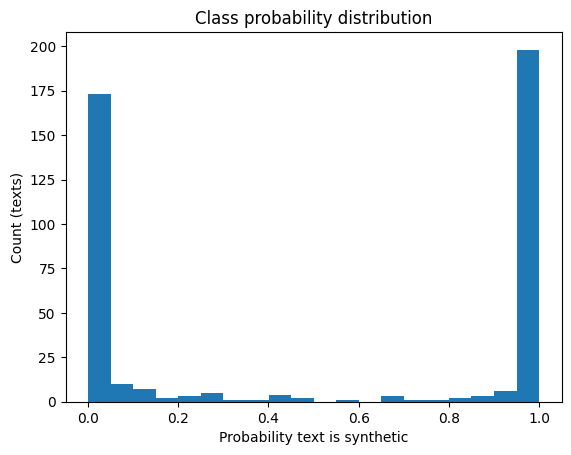

In [18]:
if Path(results_file).is_file():

    # Load the data
    with open(results_file, 'rb') as input_file:
        combined_results=pickle.load(input_file)

    results=combined_results['results']
    
    class_probabilities=[]

    for result in results:
        class_probabilities.append(result['Features']['Stage II class probability'])

    plt.title('Class probability distribution')
    plt.xlabel('Probability text is synthetic')
    plt.ylabel('Count (texts)')
    plt.hist(class_probabilities, bins=20)
    plt.savefig(f'{figure_directory}/05.8.4.4-performance_benchmark_class_probability.jpg')
    plt.show()

Wow, I still can't believe how good this thing is.

#### 4.5. Results: false positives & negatives

Now we need to make calls based on the stage II class probability. There is probably some tuning that can be done here - maybe even different thresholds for different length bins. But for now, let's just go with maximum likelihood and see where that gets us.

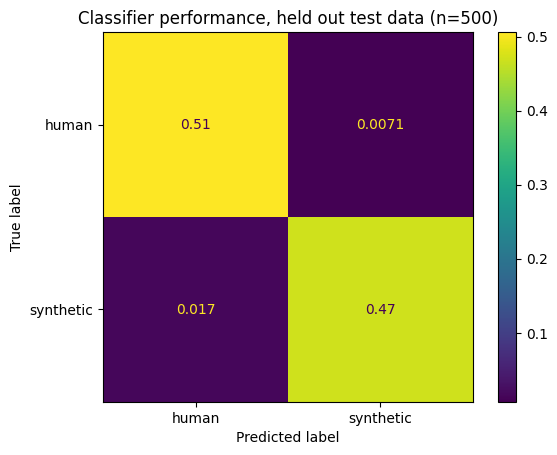

In [19]:
if Path(results_file).is_file():

    # Load the data
    with open(results_file, 'rb') as input_file:
        combined_results=pickle.load(input_file)

    results=combined_results['results']
    true_labels=combined_results['true_labels']

    predicted_labels=[]

    for result in results:

        if 'Stage II class probability' in result['Features'].keys():

            if result['Features']['Stage II class probability'] >= 0.4:
                predicted_labels.append(0)

            else:
                predicted_labels.append(1)

        else:
            print('No stage II class probability found')

    cm=confusion_matrix(true_labels, predicted_labels, normalize='all')
    cmd=ConfusionMatrixDisplay(cm, display_labels=['human','synthetic'])
    cmd.plot()

    plt.title(f'Classifier performance, held out test data (n={sample_size})')
    plt.savefig(f'{figure_directory}/05.8.4.5-performance_benchmark_confusion_matrix.jpg')
    plt.show()

Ok, looks great - slight manual adjustment of the call threshold based on the probability distribution and we're golden. This thing is a beast - I still have trouble believing how good it is. Once we get the initial deployment done, first thing to do is more training/testing on a bigger better dataset with synthetic data from more models.

## 5. Fragment length filter test

Last thing to check on is the fragment length filter. We don't want to put text into the pipeline if it doesn't fit in a length bin for both classifiers. We have a filter in place before the perplexity ratio calculation, but let's test it.

In [20]:
# Create a pipeline class instance and start the worker processes
inference_pipeline=InferencePipeline(['cuda:1'])
inference_pipeline.start()

# Try a too short text fragment
test_text='This text is too short'
inference_pipeline.input_queue.put(test_text)
result=inference_pipeline.output_queue.get()
print(result)

# Try a too long text fragment
test_text='''The Board of Public Accountants has been given the green light to move forward with legislation that
would change Montana from a two-tier licensing state to a one-tier state. As of this newsletter, HB44
has passed the House and is awaiting Senate action. If passed, the Board would no longer issue a
“certificate only” but would require all applicants to qualify for a permit to practice (license) by meeting
the 4-Es – Education, Examination, Experience, & Ethics.
Currently, a “certificate only” is mostly used by foreign applicants who do not reside in the US and have
difficulty getting a US CPA to attest to their experience to meet the requirements for a permit to
practice, but Montana residence can and do apply for the “certificate only” too. The Board considers
the two-tier system confusing to the public and is trying to eliminate the confusion. The public doesn’t
necessarily understand the qualification and restrictions for a “certificate only” and assumes a CPA is a
CPA. Some “certificate only” licensees don’t necessarily understand the restrictions either.
The draft language contains a transition period for current “certificate only” licensees to obtain the
necessary experience to elevate to the permit to practice level of licensure. The experience
requirement to obtain a permit to practice is 2000 hours of accounting and auditing functions ordinarily
required in the practice of public accounting within the preceding 3 years. Experience can come from
private, governmental, academic, or public accounting work.
All applicable experience must be attested to by a US CPA in good standing with an active license at the
time of attestation. The CPA attesting to the experience does not need to be a supervisor, but must be
familiar with the applicant’s work and be able to attest that the work meets professional standards. The
Board may also consider military experience by evaluating information provided by the applicant’s
commanding officer, outlining the duties and responsibilities of the applicant while in military service'''

inference_pipeline.input_queue.put(test_text)
result=inference_pipeline.output_queue.get()
print(result)

# Stop the pipeline
inference_pipeline.stop()

Text too short for stage II classifier.
Text too long for stage II classifier.
{'Time-of-flight': {}, 'Features': {'Text string': 'This text is too short', 'Text length (words)': 5}, 'Status': 'Error: fragment too short'}
{'Time-of-flight': {}, 'Features': {'Text string': 'The Board of Public Accountants has been given the green light to move forward with legislation that\nwould change Montana from a two-tier licensing state to a one-tier state. As of this newsletter, HB44\nhas passed the House and is awaiting Senate action. If passed, the Board would no longer issue a\n“certificate only” but would require all applicants to qualify for a permit to practice (license) by meeting\nthe 4-Es – Education, Examination, Experience, & Ethics.\nCurrently, a “certificate only” is mostly used by foreign applicants who do not reside in the US and have\ndifficulty getting a US CPA to attest to their experience to meet the requirements for a permit to\npractice, but Montana residence can and do apply

Ok - cool. Works. Let's get it in Luigi already!